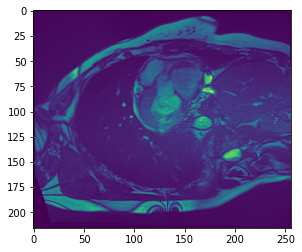

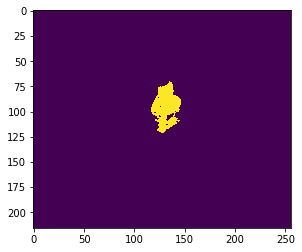

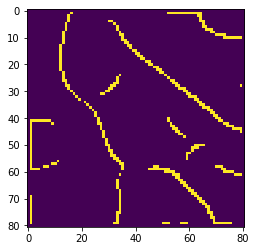

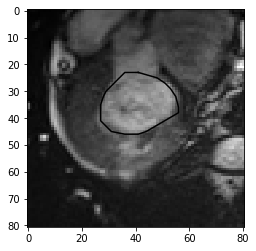

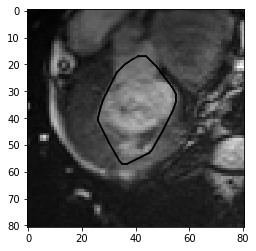

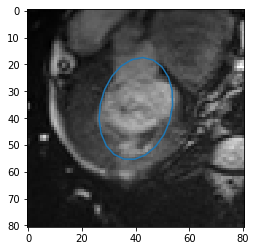

In [11]:
import os
import sys
import numpy as np
import nibabel
import nibabel as nib
from skimage.filters import threshold_multiotsu  # updated
from nibabel.testing import data_path
# sys.path.append(os.path.dirname(os.path.abspath(__file__)))
import matplotlib.pyplot as plt
from utils import *
import cv2
from skimage.morphology import convex_hull_image

from scipy.spatial import ConvexHull
from skimage import feature
import skimage



dataset_path = '../dataset/training/'
# dataset_path = r'D:\ds\training\\'


patient_list = os.listdir(dataset_path)

file_path = dataset_path + patient_list[0] + '/'
file_list = os.listdir(file_path)
for i in file_list:
    if 'frame01.' in i:
        file = file_path + i

img = nib.load(file)
img.shape[2]
info = img.header
img_data = img.get_fdata()
shape = img.shape
raw = info.structarr
xspacing = raw['pixdim'][1]
yspacing = raw['pixdim'][2]
xRadius = int(110/xspacing/2)
yRadius = int(110/yspacing/2)
width = xRadius
"""
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
"""
rawImg = img_data[:, :, 0]
# prep
init_center, center_tl, threshold = init_ROI(rawImg)
img = np.digitize(rawImg, bins=threshold)
scan_map = region_growing(img, init_center, center_tl, threshold=1)

plt.imshow(rawImg)
plt.show()
plt.imshow(scan_map)
plt.show()

cx, cy = get_convex_hull_centroid(scan_map)
cx = int(cx)
cy = int(cy)

# Li's code
i = rawImg

# edited by DJ
# img normalize
i = (i - np.min(i))/(np.max(i) - np.min(i)) * 255

roi = i[cx - xRadius:cx + xRadius+1, cy - yRadius:cy + yRadius+1]

#
thresholds = threshold_multiotsu(roi)   # updated
# T1 = thresholds[0]   # updated
TBlood = np.array([thresholds[1]])
diff = thresholds[1]-thresholds[0]

bloodRegion = np.digitize(roi, bins=TBlood)

# modified by Deng
plt.imshow(bloodRegion)

# modified canny edge
roiPolar = cv2.linearPolar(roi, (xRadius, yRadius), xRadius, cv2.WARP_FILL_OUTLIERS )
rawEdge = modifiedCanny(roiPolar, sigma=8)
TD, BU = edgeCandidate(rawEdge)
edgeX, edgeY = getEdgeCoordinate(TD, BU)
edgeX = np.concatenate((edgeX, edgeX[0:1]))
edgeY = np.concatenate((edgeY, edgeY[0:1]))
plt.imshow(roi,cmap='gray')
plt.plot(edgeX, edgeY, 'k-')
plt.show()


# region growing base on the thresholding result 
regionBloodPloar = cv2.linearPolar(bloodRegion, (xRadius, yRadius), xRadius, cv2.WARP_FILL_OUTLIERS )
yPos = 0
while regionBloodPloar[0,yPos]!=1:
    yPos = np.random.randint(yRadius)
seed = [0, yPos]
polarGrowing = region_growing(regionBloodPloar,regionBloodPloar,[0,0],seed=seed, threshold=1)
plt.imshow(polarGrowing)
growingCart = cv2.linearPolar(polarGrowing.astype(np.float), (xRadius, yRadius), xRadius, cv2.WARP_INVERSE_MAP + cv2.WARP_FILL_OUTLIERS)


chull = convex_hull_image(growingCart)
plt.imshow(chull)
x,y = np.where(chull==1)
newP = clockwise(x,y)
hullP = newP.T
hull = ConvexHull(hullP)

x, y = getConvexPoint(hull, hullP)
plt.plot(x, y, 'k-')
for simplex in hull.simplices:
    plt.plot(hullP[simplex, 1], hullP[simplex, 0], 'k-')
plt.imshow(roi, cmap='gray')
plt.show()


# FFT smoothing

sx,sy = fftSmooth(0.05, x,y)
sx = np.concatenate((sx,sx[0:1]))
sy = np.concatenate((sy,sy[0:1]))

plt.plot(sx,sy,'-')
plt.plot
plt.imshow(roi,cmap='gray')

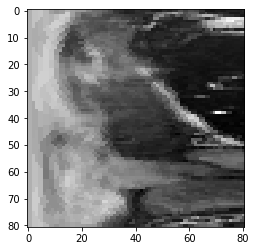

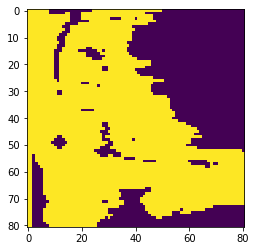

In [37]:

regionBloodPloar = cv2.linearPolar(roi, (xRadius, yRadius), xRadius, cv2.WARP_FILL_OUTLIERS )
plt.imshow(regionBloodPloar, cmap='gray')
plt.show()
growingPolar = region_growing(regionBloodPloar, regionBloodPloar, [0,0], seed=[0,0], threshold=10)
plt.imshow(growingPolar)
plt.show()

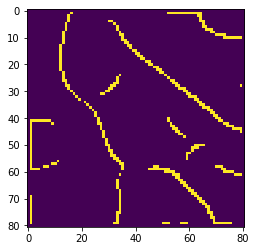

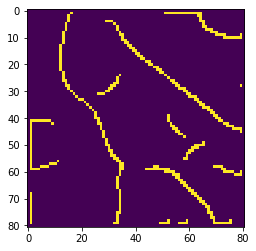

In [41]:
edgePolar = skimage.feature.canny(regionBloodPloar, sigma=8)
plt.imshow(edgePolar)
plt.show()
gauEdgePolar = skimage.filters.gaussian(edgePolar.astype(np.float),sigma=1)
smoothEdgePolar = np.digitize(gauEdgePolar, bins=np.array([0.1*np.max(gauEdgePolar)]))
thiningEdgePolar = skimage.morphology.skeletonize(smoothEdgePolar)
combine = thiningEdgePolar + edgePolar
combine = np.digitize(combine, bins=np.array([0.1]))
plt.imshow(combine)
plt.show()

In [42]:
# find a satisfied edges

# how to select?
# choose the longest top down line
# check reach the bottom or not
# if not, choose the longest bottom up line
# check overlap, choose the further one
seedY = np.where(combine[1,:]==1)
seedY = seedY[0]
shape = edgePolar.shape
maxYD = 0

# top down
for i in seedY:
    temp = region_growing(combine.astype(np.float), combine.astype(np.float),
                          [0,0], seed=[1,i], threshold=1, n=8)
    y,x = np.where(temp==2)
    yDisparity = np.max(y) - np.min(y)
    if yDisparity > maxYD:
        maxYD = yDisparity
        candidateTD = temp
        
# check bottom reach
if maxYD >= combine.shape[1] - 3:
    print('reach bottom')
    candidateBU = candidateTD
else:
    maxYD = 0
    seedY = np.where(combine[-2,:]==1)
    seedY = seedY[0]
    for i in seedY:
        temp = region_growing(combine.astype(np.float), combine.astype(np.float),
                          [0,0], seed=[-2,i], threshold=1, n=8)
        y,x = np.where(temp==2)
        yDisparity = np.max(y) - np.min(y)
        if yDisparity > maxYD:
            maxYD = yDisparity
            candidateBU = temp

            

reach bottom


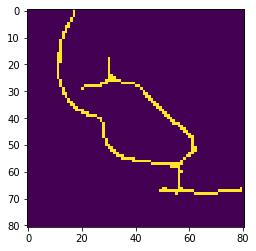

In [40]:
plt.imshow(candidateTD)

In [1]:
def modifiedCanny(img, sigma=8):
    edgePolar = skimage.feature.canny(img, sigma=sigma)
    plt.imshow(edgePolar)
    plt.show()
    gauEdgePolar = skimage.filters.gaussian(edgePolar.astype(np.float),sigma=0.5)
    smoothEdgePolar = np.digitize(gauEdgePolar, bins=np.array([0.1*np.max(gauEdgePolar)]))
    thiningEdgePolar = skimage.morphology.skeletonize(smoothEdgePolar)
    combine = thiningEdgePolar + edgePolar
    combine = np.digitize(combine, bins=np.array([0.1]))
    return combine

def edgeCandidate(edge):
    seedY = np.where(edge[1,:]==1)
    seedY = seedY[0]
    shape = edge.shape
    maxYD = 0

    # top down
    for i in seedY:
        temp = region_growing(edge.astype(np.float), edge.astype(np.float),
                              [0,0], seed=[1,i], threshold=1, n=8)
        y,x = np.where(temp==2)
        yDisparity = np.max(y) - np.min(y)
        if yDisparity > maxYD:
            maxYD = yDisparity
            candidateTD = temp

    # check bottom reach
    if maxYD >= edge.shape[1] - 3:
        candidateBU = candidateTD
        return candidateTD, candidateBU
    else:
        seedY = np.where(edge[-2,:]==1)
        seedY = seedY[0]
        for i in seedY:
            temp = region_growing(edge.astype(np.float), edge.astype(np.float),
                              [0,0], seed=[-2,i], threshold=1, n=8)
            y,x = np.where(temp==2)
            yDisparity = np.max(y) - np.min(y)
            if yDisparity > maxYD:
                maxYD = yDisparity
                candidateBU = temp
    return candidateTD, candidateBU

def getEdgeCoordinate(candidateTD, candidateBU):
    # if overlap
    rTD, cTD = np.where(candidateTD!=0)
    rBU, cBU = np.where(candidateBU!=0)
    if max(rTD) >= min(rBU):
        overlapMask = np.ones_like(candidateTD)
        overlapMask[min(rBU):-1, :] = 0
        candidateTD = candidateTD*overlapMask

    finalEdge = candidateTD + candidateBU
    finalEdge = cv2.linearPolar(finalEdge.astype(np.float), (xRadius, yRadius), xRadius, cv2.WARP_FILL_OUTLIERS+cv2.WARP_INVERSE_MAP )
    # if not overlap


    # plt.imshow(finalEdge)
    r, c = np.where(finalEdge!=0)
    newP = clockwise(r,c)
    hullP = newP.T
    hull = ConvexHull(hullP)
    x, y = getConvexPoint(hull, hullP)
    return x,y


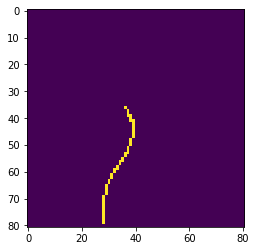

In [6]:
plt.imshow(candidateTD)
plt.imshow(candidateBU)
rTD, cTD = np.where(candidateTD==2)
rBU, cBU = np.where(candidateBU==2)

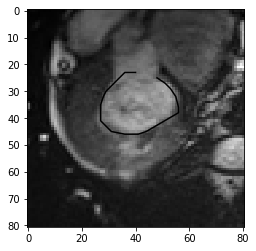

In [43]:
# if overlap
if max(rTD) >= min(rBU):
    overlapMask = np.ones_like(candidateTD)
    overlapMask[min(rBU):-1, :] = 0
    candidateTD = candidateTD*overlapMask

finalEdge = candidateTD + candidateBU
finalEdge = cv2.linearPolar(finalEdge.astype(np.float), (xRadius, yRadius), xRadius, cv2.WARP_FILL_OUTLIERS+cv2.WARP_INVERSE_MAP )
# if not overlap


# plt.imshow(finalEdge)
r, c = np.where(finalEdge!=0)
newP = clockwise(r,c)
hullP = newP.T
hull = ConvexHull(hullP)
x, y = getConvexPoint(hull, hullP)
plt.imshow(roi,cmap='gray')
plt.plot(x, y, 'k-')

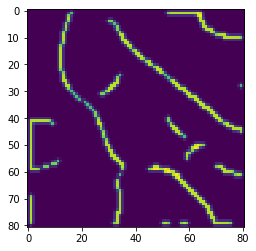

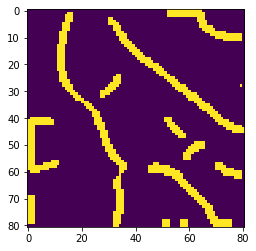

0.8926065400111675

In [72]:
gauEdgePolar = skimage.filters.gaussian(edgePolar.astype(np.float),sigma=0.5)
temp = np.digitize(gauEdgePolar, bins=np.array([0.1*np.max(gauEdgePolar)]))
plt.imshow(temp)
plt.show()
np.max(gauEdgePolar)

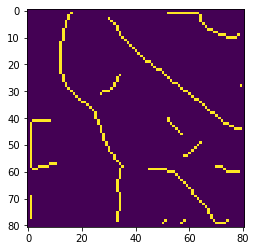

In [75]:
thining = skimage.morphology.skeletonize(temp)
plt.imshow(thining)

In [59]:
np.array(0.1*np.max(gauEdgePolar))

array(0.07643783)

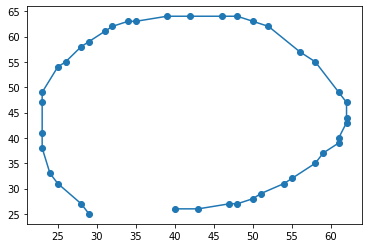

In [49]:
# smooth with FIR
origLen = len(x)
temp_x = np.concatenate((x, x[0:1]))
temp_y = np.concatenate((y, y[0:1]))
for it in range(1):
    for i in range(origLen):
        temp_x[i] = (1*temp_x[i-1] + 1*temp_x[i+1] + 8*temp_x[i])/10
        temp_y[i] = (1*temp_y[i-1] + 1*temp_y[i+1] + 8*temp_y[i])/10
    temp_x[-1] = temp_x[0]
    temp_x[-2] = temp_x[1]
    # plt.plot(temp_x[0:-1],temp_y[0:-1],'-o')
    # plt.imshow
plt.plot(x,y,'-o')


In [57]:
np.max(gauEdgePolar)

0.7643782572312177

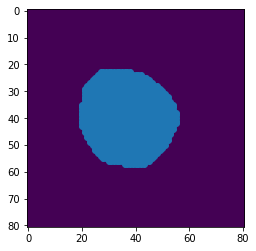

In [58]:
plt.plot(newP[1,:],newP[0,:],'o')
plt.imshow(chull)

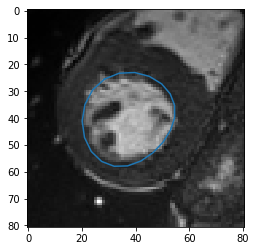

In [249]:
# FFT smoothing
signal = x + 1j*y
# FFT and frequencies
fft = np.fft.fft(signal)
freq = np.fft.fftfreq(signal.shape[-1])
# filter
cutoff = 0.11
fft[np.abs(freq) > cutoff] = 0
# IFFT
signal_filt = np.fft.ifft(fft)


sx = signal_filt.real
sy = signal_filt.imag
sx = np.concatenate((sx,sx[0:1]))
sy = np.concatenate((sy,sy[0:1]))

plt.plot(sx,sy,'-')
plt.plot
plt.imshow(roi,cmap='gray')

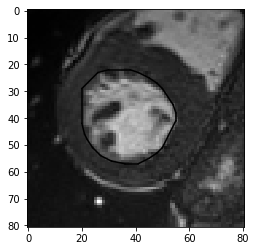

In [400]:
from scipy.spatial import ConvexHull
x,y = np.where(chull==1)
newP = clockwise(x,y)
hullP = newP.T
hull = ConvexHull(hullP)
plt.imshow(roi, cmap='gray')
for simplex in hull.simplices:
    plt.plot(hullP[simplex, 1], hullP[simplex, 0], 'k-')
plt.show()

In [170]:
hull.simplices

array([[ 11,   2],
       [ 46,  56],
       [ 91,  83],
       [ 91,  95],
       [ 62,  56],
       [ 79,  83],
       [ 21,  28],
       [ 39,  46],
       [113,   2],
       [103,  95],
       [103, 107],
       [ 66,  73],
       [ 66,  62],
       [ 75,  73],
       [ 75,  79],
       [ 15,  11],
       [ 15,  21],
       [ 32,  28],
       [ 32,  39],
       [109, 107],
       [109, 113]], dtype=int32)

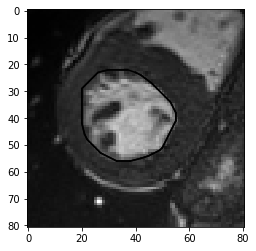

In [333]:
# get convex hull boundary points
def getConvexPoint(hull, hullP):
    a = hullP[hull.simplices, 0]
    a = np.reshape(a, [-1])
    b = hullP[hull.simplices, 1]
    b = np.reshape(b, [-1])
    c = np.column_stack((a,b))
    c = np.unique(c, axis=1)
    a = c[:,0]
    b = c[:,1]
    c = clockwise(a,b)
    return c[1,:], c[0,:]

x, y = getConvexPoint(hull, hullP)
plt.plot(x, y, 'k-')
for simplex in hull.simplices:
    plt.plot(hullP[simplex, 1], hullP[simplex, 0], 'k-')
plt.imshow(roi, cmap='gray')
plt.show()

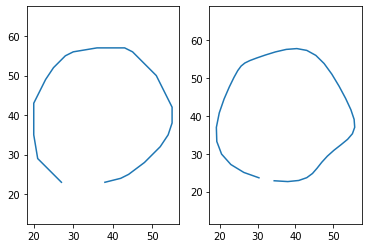

In [5]:
# FFT smoothing
signal = x + 1j*y
# FFT and frequencies
fft = np.fft.fft(signal)
freq = np.fft.fftfreq(signal.shape[-1])
# filter
cutoff = 0.1
fft[np.abs(freq) > cutoff] = 0
# IFFT
signal_filt = np.fft.ifft(fft)

plt.figure()
plt.subplot(121)
plt.axis('equal')
plt.plot(x, y, label='Noisy')
plt.subplot(122)
plt.axis('equal')
plt.plot(signal_filt.real, signal_filt.imag, label='Smooth')

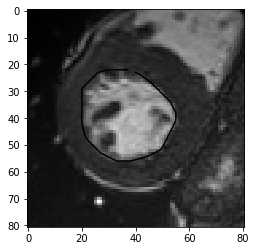

In [321]:
plt.plot(x, y, 'k-')
plt.imshow(roi, cmap='gray')

In [294]:
c.shape

(2, 40)

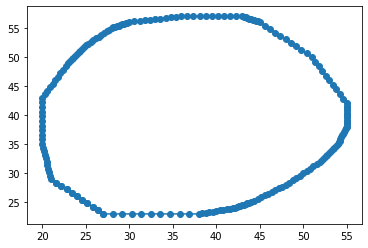

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# x,y = counterclockwise(x,y)
orig_len = len(x)

x_array = np.concatenate([x, x[0:5]])
y_array = np.concatenate([y, y[0:5]])

# x = x_array
# y = y_array

# x = x[-3:-1] + x + x[1:3]
# y = y[-3:-1] + y + y[1:3]
# c = x + 1j*y
t = np.arange(len(x_array))
ti = np.linspace(2, orig_len-1, 10 * orig_len)

xi = interp1d(range(len(x_array)), x_array, kind='linear')
yi = interp1d(range(len(x_array)), y_array, kind='linear')

newX = xi(np.arange(0,orig_len+1,0.1))
newY = yi(np.arange(0,orig_len+1,0.1))
# ax.plot(c.real, c.imag,'-')
plt.plot(newX, newY,'-o')

plt.show()

In [201]:
xi

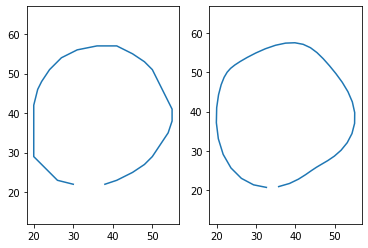

In [395]:

signal = x + 1j*y
# FFT and frequencies
fft = np.fft.fft(signal)
freq = np.fft.fftfreq(signal.shape[-1])
# filter
cutoff = 0.1
fft[np.abs(freq) > cutoff] = 0
# IFFT
signal_filt = np.fft.ifft(fft)

plt.figure()
plt.subplot(121)
plt.axis('equal')
plt.plot(x, y, label='Noisy')
plt.subplot(122)
plt.axis('equal')
plt.plot(signal_filt.real, signal_filt.imag, label='Smooth')

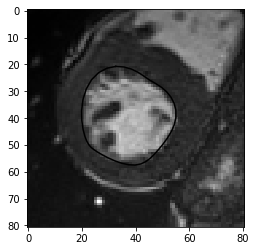

In [387]:
sx = signal_filt.real
sy = signal_filt.imag
sx = np.concatenate((sx,sx[0:1]))
sy = np.concatenate((sy,sy[0:1]))

plt.plot(sx,sy,'k-')
plt.plot
plt.imshow(roi,cmap='gray')

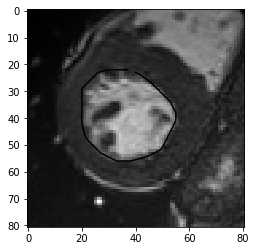

In [342]:
plt.plot(x, y, 'k-')
plt.imshow(roi, cmap='gray')

In [415]:
x

array([30, 30, 26, 26, 20, 20, 20, 20, 21, 21, 22, 22, 24, 24, 27, 27, 31,
       31, 36, 36, 41, 41, 45, 45, 48, 48, 50, 50, 55, 55, 55, 55, 54, 54,
       50, 50, 48, 48, 45, 45, 41, 41, 38, 38])

In [75]:
img = cv2.convertScaleAbs(chull.astype(np.int8))
i, contour, h= cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
P = contour[0]
P = np.reshape(P, [-1,2])
plt.plot(P[:,0], P[:,1])

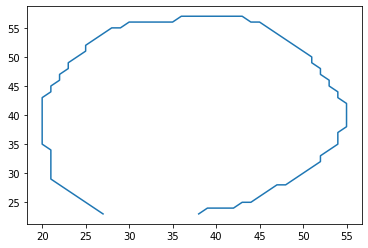

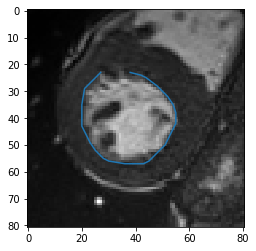

In [98]:
newHull = ConvexHull(P)
x, y = getConvexPoint(newHull, P)
plt.plot(x, y)
plt.imshow(roi, cmap='gray') 

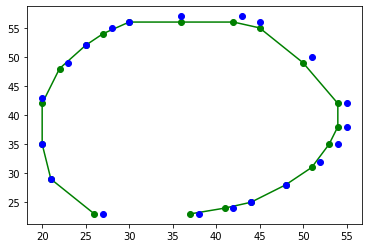

In [176]:
# smooth with FIR
origLen = len(x)
temp_x = np.concatenate((x, x[0:1]))
temp_y = np.concatenate((y, y[0:1]))
for it in range(1):
    run_x = np.zeros_like(temp_x)
    run_y = np.zeros_like(temp_y)
    for i in range(origLen):
        run_x[i] = (1*temp_x[i-1] + 1*temp_x[i+1] + 8*temp_x[i])/10
        run_y[i] = (1*temp_y[i-1] + 1*temp_y[i+1] + 8*temp_y[i])/10
    temp_x = run_x
    temp_y = run_y
    temp_x[-1] = temp_x[0]
    temp_y[-1] = temp_y[0]
    
    # plt.imshow
plt.plot(temp_x[0:-1],temp_y[0:-1],'-go')
plt.plot(x,y,'bo')

In [109]:
x[0:5]

array([27, 27, 21, 21, 20], dtype=int32)

In [110]:
y[0:5]

array([23, 23, 29, 29, 35], dtype=int32)

In [112]:
x,y = getConvexPoint(newHull, P)

In [152]:
def getConvexPoint(hull, hullP):
    a = hullP[hull.simplices, 0]
    a = np.reshape(a, [-1])
    b = hullP[hull.simplices, 1]
    b = np.reshape(b, [-1])
    c = np.column_stack((a,b))
    # c = np.unique(c, axis=1)
    # a = c[:,0]
    # b = c[:,1]
    # c = clockwise(a,b)
    return c

In [153]:
c = getConvexPoint(newHull, P)

In [158]:
np.unique(c,axis=0)

array([[20, 35],
       [20, 43],
       [21, 29],
       [23, 49],
       [25, 52],
       [27, 23],
       [28, 55],
       [30, 56],
       [36, 57],
       [38, 23],
       [42, 24],
       [43, 57],
       [44, 25],
       [45, 56],
       [48, 28],
       [51, 50],
       [52, 32],
       [54, 35],
       [55, 38],
       [55, 42]], dtype=int32)

In [138]:
np.unique(c,1)

(array([20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 35, 36, 38, 42, 43, 44, 45,
        48, 49, 50, 51, 52, 54, 55, 56, 57], dtype=int32),
 array([ 0,  2, 36, 48, 34,  4, 32, 42, 30, 54, 40, 28,  6,  8, 26, 10, 24,
        12, 76, 62, 22, 14, 16, 18, 64, 66]))

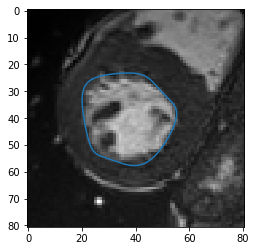

In [216]:
# FFT smoothing
signal = newX + 1j*newY
# FFT and frequencies
fft = np.fft.fft(signal)
freq = np.fft.fftfreq(signal.shape[-1])
# filter
cutoff = 0.02
fft[np.abs(freq) > cutoff] = 0
# IFFT
signal_filt = np.fft.ifft(fft)


sx = signal_filt.real
sy = signal_filt.imag
sx = np.concatenate((sx,sx[0:1]))
sy = np.concatenate((sy,sy[0:1]))

plt.plot(sx,sy,'-')
plt.plot
plt.imshow(roi,cmap='gray')

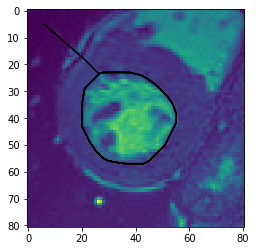

In [248]:
#!python

from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show


#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------


nsamples = len(x)
sample_rate = nsamples/4
# t = arange(nsamples) / sample_rate
# x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
#         0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
#             0.1*sin(2*pi*23.45*t+.8)
temp_x = np.concatenate((newX, newX, newX))
temp_y = np.concatenate((newY, newY, newY))

#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 30.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 0.01

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, temp_x)
filtered_y = lfilter(taps, 1.0, temp_y)
plt.plot(filtered_x, filtered_y, 'k-')
plt.imshow(roi)

In [220]:
len(newX)

210

In [221]:
len(newX)

210

In [4]:
edgeX

array([41, 36, 29, 28, 27, 27, 31, 36, 41, 44, 56, 56, 55, 53, 51, 48])

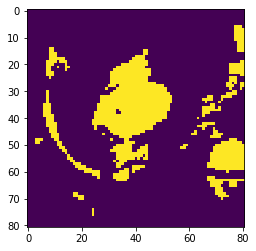

NameError: name 'modifiedCanny' is not defined

In [8]:

from segment import segLV

t = segLV(rawImg, width)

In [ ]:
def expension(x, y, pixNum=2):
    x_new = np.zeros_like(x)
    y_new = np.zeros_like(y)
    for i = 1:range(len(x)):
        norm = (x[i]^2 + y[i^2])^(1/2)
        scale = (norm +pixNum)/norm
        x_new[i] = scale*x[i]
        y_new[i] = scale*y[i]
    return x_new, y_new

In [ ]:
def expension(x, y, pixNum=2):
    x_new = np.zeros_like(x)
    y_new = np.zeros_like(y)
    for i = 1:range(len(x)):
        norm = (x[i]^2 + y[i^2])^(1/2)
        scale = (norm +pixNum)/norm
        x_new[i] = scale*x[i]
        y_new[i] = scale*y[i]
    return x_new, y_new